In [11]:
import os
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [2]:
def shift_and_scale(group: pd.DataFrame) -> pd.DataFrame:
    """ Shift and scales the 'x' and 'y' values in the given DataFrame group. 
    
    Args:
        group (pd.DataFrame): A DataFrame group with columns 'x' and 'y' to shift and scale.
        
    Returns:
         pd.DataFrame: The shifted and scaled DataFrame group.
    """
    # Check if all 'x' and 'y' values in the group are withing the specified range
    if group['x'].between(-50, -40).all() and group['y'].between(40, 50).all():
        # If so, shift all 'x' values by +45 and all 'y' values by -45
        group['x'] += 45
        group['y'] -= 45
        
        #Scale spiral coordinates to math the reference spiral
        group['x'] *= 10
        group['y'] *= 10
        
    #drop the index to avoid duplication
    group = group.reset_index(drop=True)
    return group

In [3]:
def generate_reference(num_points: int = 5000, b: float = 1.075) -> np.ndarray:
    """ Generates a reference spiral with the given number of points and scaling factor.
    
    Args:
        num_point (int, optional): The number of points to generate for the reference spiral.
            Defaults to 5000.
        b (float, optional): The scaling factor for the reference spiral. Defaults to 1.075.
    
    Returns:
        np.ndarray: A numpy array with the generated reference spiral coordinates.
    """
    t = np.linspace(0, 8*np.pi, num_points)
    arc_length = (b / 2) * (t * np.sqrt(1 + t**2) + np.log(t + np.sqrt(1 + t**2)))
    arc_length_equidistant = np.linspace(0, arc_length[-1], num_points)
    f_theta = interp1d(arc_length, t, kind='cubic', fill_value='extrapolate')
    t_interp = f_theta(arc_length_equidistant)
    x_ref = b * t_interp * np.cos(t_interp)
    y_ref = b * t_interp * np.sin(t_interp)
    ref = np.column_stack((x_ref, y_ref))
    return ref


In [4]:
def remove_duplicate(group: pd.DataFrame) -> pd.DataFrame:
    """ Removes duplicate points from the given DataFrame group.
    
    Args:
        group (pd.DataFrame): A DataFrame group with columns 'x' and 'y' to remove duplicates.
        
    Returns:
        pd.DataFrame: The DataFrame group with duplicates removed.
    """
    # Create a temporary reference spiral 
    ref = generate_reference()
    # Calculate the Euclidean distance between the group coordinates and the reference spiral
    dist = distance.cdist(group[['x', 'y']], ref, 'euclidean')
    # Find the minimum distance for each group coordinate
    group['dist'] = np.min(dist, axis=1)
    #sort the values by timestamp distance and UTC timestamp
    group = group.sort_values(by=['UTC_Timestamp', 'dist'])
    # drop duplicates based on UTC_Timestamp, keeping the first occurence
    # (which has the shortest distance to the reference spiral, due to the sorting)
    group = group.drop_duplicates(subset='UTC_Timestamp', keep='first')
    #drop the dist column
    group = group.drop(columns='dist')
    #reset the index
    group = group.reset_index(drop=True)    
    return group

In [5]:
def keep_longest_line(group: pd.DataFrame) -> pd.DataFrame:
    """ Keeps only the longest line segment in the given DataFrame group.
    
    Args:
        group (pd.DataFrame): A DataFrame group with columns 'x' and 'y' to keep the longest line segment.
        
    Returns:
        pd.DataFrame: The DataFrame group with only the longest line segment.
    """
   # group by line number and get the sie of each group. 
    # find the line_number with the maximum size
    longest_line = group.groupby('line_number').size().idxmax()
    # filter the group to keep only the longest line
    group = group[group['line_number'] == longest_line]
    #reset the index
    group = group.reset_index(drop=True)
    
    return group

In [6]:
def drop_overlapping_time_window(group: pd.DataFrame) -> pd.DataFrame:
    """ Drops rows from the input group Dataframe that have overlapping time windows.
    
    Args:
        group (pd.DataFrame): A DataFrame group with columns 'x' and 'y' to drop overlapping time windows.
        
    Returns:
        pd.DataFrame: The DataFrame group with rows that have overlapping time windows dropped.
    """
    # Create a dictionary of time windows for each line number
    time_windows = {line_number: (
        group.loc[group['line_number'] == line_number, 'UTC_Timestamp'].min(),
        group.loc[group['line_number'] == line_number, 'UTC_Timestamp'].max()
    ) for line_number in group['line_number'].unique()}
    
    #create a set to store the line_numbers to drop
    lines_to_drop = set()
    
    # Iterate through each line number and compare it's time window with all other time windows
    for line_number, time_window in time_windows.items():
        for other_line_number, other_time_window in time_windows.items():
            if line_number != other_line_number:
                # check if the time windows overlap
                if max(time_window[0], other_time_window[0]) <= min(time_window[1], other_time_window[1]):
                    # if there is overlap, drop the shorter line
                    if group.loc[group.line_numner == line_number].shape[0] <= \
                        group.loc[group.line_number == other_line_number].shape[0]:
                        lines_to_drop.add(line_number)
                    else:
                        lines_to_drop.add(other_line_number)
                        
    # drop the rows with overlapping time windows
    group  = group[~group['line_number'].isin(lines_to_drop)]
    group = group.reset_index(drop=True)
    return group
    

In [35]:
def cart2polar(group: pd.DataFrame) -> pd.DataFrame:
    # Convert the 'x' and 'y' values to polar coordinates
    group['r'] = np.sqrt(group['x']**2 + group['y']**2)
    group['theta'] = np.arctan2(group['y'], group['x'])
    #group['theta_diff'] = [np.nan] + np.diff(group['theta']).tolist()

    #flip = np.where(group['theta_diff'] < -3)[0]

    #for f in flip:

     #   group['theta'][f+1:] += 2*np.pi


    return group

# Reference Spiral 

In [36]:
# create an archimese spiral with 10000 points
ref = generate_reference(10000)
ref = pd.DataFrame(ref, columns=['x', 'y'])
ref= cart2polar(ref)

In [37]:
# import a single case
dat = pd.read_csv('/Users/bryan.gonzalez/PycharmProjects/MOBI2024/SPIRAL/Data/Clean_Oak_AWS_06012024/MoBi_Harlem_3/drawing-responses-Mon Jun 03 2024/61ab8ffb-8919-46d5-88e8-36495f70a149-c3c6111b-372a-409e-9263-b6b9c8876e86-spiral_recall1_Dom.csv')
dat = cart2polar(dat)

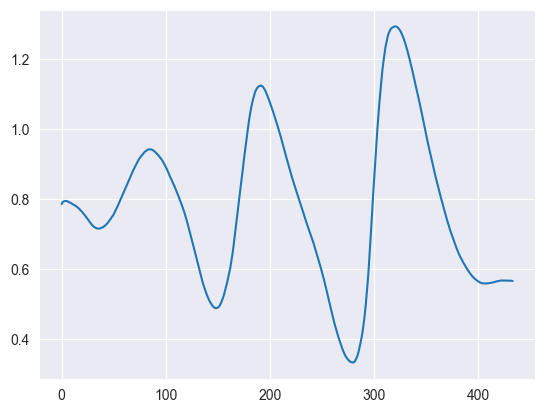

In [38]:
plt.plot(dat['theta'])

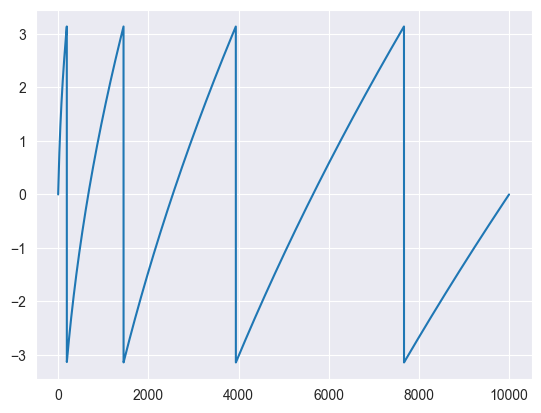

In [39]:
plt.plot(ref['theta'])

In [42]:
# Find places where theta in dat is roughly equal to theta in ref
def roughly_equal(a, b, tolerance=1e-5):
    """
    Checks if two numbers are roughly equal within a given tolerance.
    
    Parameters:
    a (float): The first number.
    b (float): The second number.
    tolerance (float): The maximum difference for the numbers to be considered equal. Default is 1e-5.
    
    Returns:
    bool: True if the numbers are roughly equal, False otherwise.
    """
    return abs(a - b) <= tolerance

pd.concat([dat, ref], axis=1).apply(lambda row: roughly_equal(row['theta'], row['theta']), axis=1)

,theta,theta
0,True,True
1,True,True
2,True,True
3,True,True
4,True,True
...,...,...
9995,False,True
9996,False,True
9997,False,True
9998,False,True


In [40]:
abs(dat['theta'] - ref['theta'])

0       0.785398
1       0.759161
2       0.729414
3       0.698720
4       0.667611
          ...   
9995         NaN
9996         NaN
9997         NaN
9998         NaN
9999         NaN
Name: theta, Length: 10000, dtype: float64